In [482]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc


plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

# LTE Downlink

Este notebook tiene por objetivo analizar el downlink de la trama tipo 1 (FDD) a partir de una señal generada por el tollbox de Matlab de LTE.
Errores de hardware (frecuencia central (CFO), en la frecuencia de muestreo, IQ , etc) quedan fuera de este analisis.



In [483]:
x=np.fromfile("TM1_15RB_FDD.dat",dtype=np.complex64)
fs=3.84e6
ts=1/fs
f=np.fft.fftshift(np.fft.fftfreq(len(x),ts))
t=np.linspace(0,len(x)*ts,len(x))
len(x)

38400

In [484]:
espec=20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))

PAR 10.300913 dB


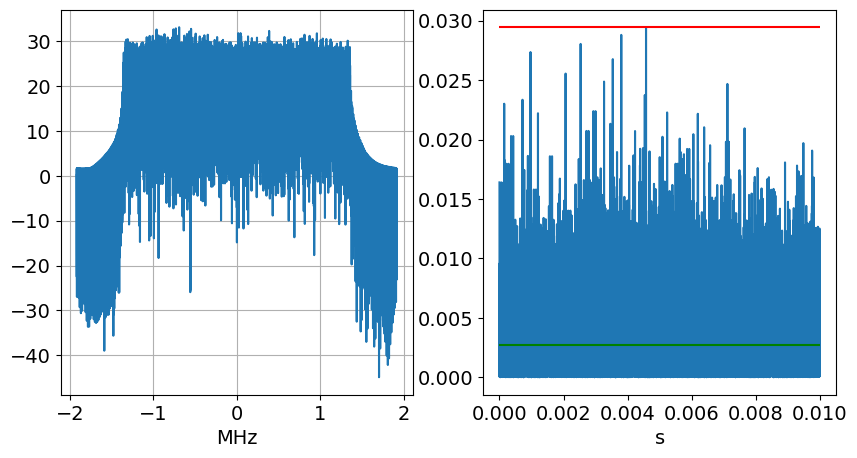

In [485]:
plt.subplot(1,2,1)
plt.plot(f/1e6,espec)
plt.xlabel("MHz")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(t,(x*np.conjugate(x)).real)
plt.hlines(np.max((x*np.conjugate(x)).real),xmin=0,xmax=t[-1],colors="r")
plt.hlines(np.mean((x*np.conjugate(x)).real),xmin=0,xmax=t[-1],colors="g")
plt.xlabel("s")

PAR=10*np.log10(np.max((x*np.conjugate(x)).real)/np.mean(x*np.conjugate(x)))
print("PAR", np.abs(PAR), "dB")


# parametros LTE

El parámetro de OFDM que permanece constante la separación de frecuencia (subcarrier spacing SCS). Luego puede deducirse para cada tamaño de FFT la frecuencia de muestreo.
Como la mayoria de los telefonos soportaria 2-3-4G, se guardó compatibilidad con el chiprate de 3G de 3.84M

<img src="parametros4G.png">


<img src="TM1_15RB_FDD.bmp">


In [486]:
# unidades en nº de muestras
Tu = 256 # tamaño de la FFT para 3MHz de BW
Ncarriers=181 # numero de portadoras con datos para 3MHz

cp_len = round(fs*4.7e-6)  # 4.7 usecs,
cp_len2 = round(fs*5.2e-6)  # 5.2 usecs, 


print("cp_len=", cp_len, "muestras")
print("cp_len2=",cp_len2, "muestras")

cp_len= 18 muestras
cp_len2= 20 muestras


# Señales de sincronización

el eNodeB lle transmite al UE 2 señales para poder sincronizarse y encontrar la PCI (physical Cell ID)
- PSS
- SSS

que se envian es zonas especificas de la trama, esto es al final del slot#0 del subframe#0 y al final de slot#10 del subframe#5
La secuencia de SSS en la subframe#0 y la de la subframe#5 son diferentes entre sí.

Estas señales solo ocupan los 6 RB centrales (1.08 MHz), de manera que sean compatibles con todos los anchos de banda posibles de la celda (LTE admite anchos de banda de celda de 1.4, 3, 5, 10, 15 y 20 MHz) y puedan ser recibidas por un UE que aún no conoce el ancho de banda de la celda.

Podemos ver que en cada transmisión de PSS y SSS hay otra transmisión de 1.08 MHz que la sigue. Esto corresponde al PBCH, una vez en cada trama de radio. El PBCH es  más ancho que el PSS y el SSS. Esto se debe a que el PSS y el SSS solo utilizan 62 de los 72 subportadores centrales en los 6 RB que ocupan, dejando 5 subportadoras en cada borde como banda de guarda.


## Cell ID

El PCI se define como

$ PCI = 3N_{\text{ID}^{(1)}} + N_{\text{ID}^{(2)}} $

$ N_{\text{ID}^{(1)}}$ es el grupo, que puede ir de 0 a 167

$N_{\text{ID}^{(2)}} $ es la identidad dentro del grupo que puede valer de 0 a 2

# PSS

La PSS (primary syncronization signal) es la identidad dentro del grupo. Está basada en las secuencias de Zadoff-Chu. 
Estos códigos tienen la propiedad de tener autocorrelación cíclica cero en todos los retrasos distintos de cero.

<img src="pss.png">

In [487]:
# La PSS ocupa 3RB a cada lado del DC y deja 5RE sin potencia a  6*12 y no utiliza 5 subportadoras a cada llado

subcarriers_ss = slice(Tu//2 - 3*12 + 5, Tu//2 + 3*12 - 5 + 1)
print("subcarriers",Tu//2 - 3*12 + 5, "a",Tu//2 + 3*12 - 5 + 1, " el SSB ocupa ", (Tu//2 + 3*12 - 5 + 1) - (Tu//2 - 3*12 + 5),"portadoras" )

subcarriers 97 a 160  el SSB ocupa  63 portadoras


In [488]:
def zadoff_chu(u):
    n = np.arange(63)
    a = np.exp(-1j*np.pi*u*n[0:31]*(n[0:31]+1)/63)
    b = np.asarray([0])  #  DC subcarrier
    c = np.exp(-1j*np.pi*u*(n[31:62]+1)*(n[31:62]+2)/63)
    x=np.concatenate((a,b,c))
    return x

print (len(zadoff_chu(25)))



63


Text(0.5, 0.98, 'Secuencias Zadoff-Chu')

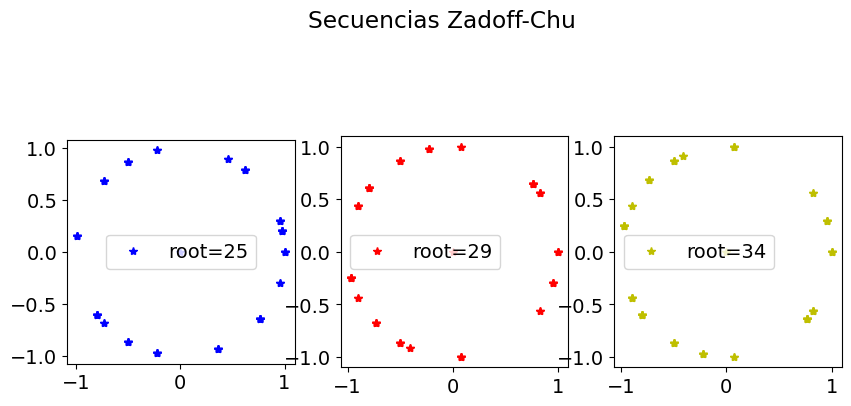

In [489]:


plt.subplot(1,3,1)
plt.plot(zadoff_chu(25).real,zadoff_chu(25).imag,"*b")
plt.legend(["root=25"])
plt.gca().set_aspect('equal', adjustable='box')


plt.subplot(1,3,2)
plt.plot(zadoff_chu(29).real,zadoff_chu(29).imag,"*r")
plt.legend(["root=29"])
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,3,3)
plt.plot(zadoff_chu(34).real,zadoff_chu(34).imag,"*y")
plt.legend(["root=34"])
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle("Secuencias Zadoff-Chu")


In [490]:
zc_u = [25, 29, 34] # los root index definidos en la norma
zc_time = np.empty((3, Tu), 'complex')
for j in range(3):
    zc = zadoff_chu(zc_u[j])
    zc_all = np.zeros(Tu, 'complex')
    zc_all[subcarriers_ss] = zc
    zc_time[j] = np.fft.ifft(np.fft.fftshift(zc_all))

Text(0.5, 0.98, 'Representación temporal de las secuencias de Zadoff-Chu')

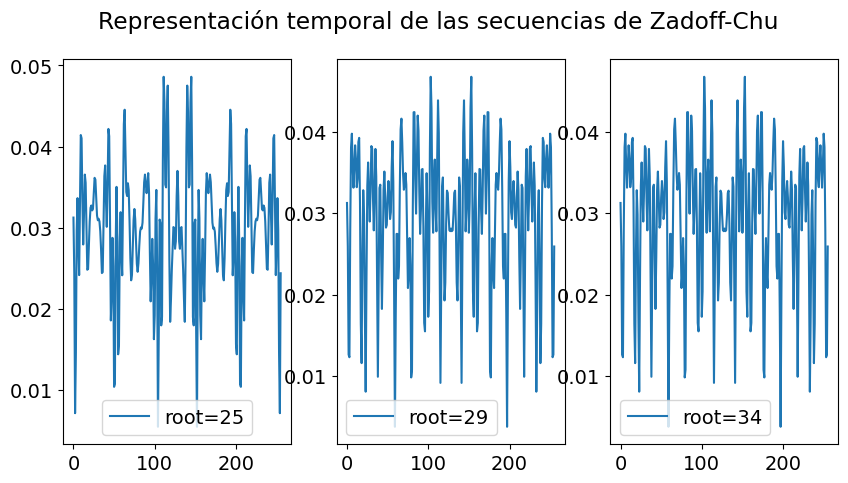

In [491]:
plt.subplot(1,3,1)
plt.plot(np.abs(zc_time[0]))
plt.legend(["root=25"])
plt.subplot(1,3,2)
plt.plot(np.abs(zc_time[1]))
plt.legend(["root=29"])
plt.subplot(1,3,3)
plt.plot(np.abs(zc_time[2]))
plt.legend(["root=34"])
plt.suptitle("Representación temporal de las secuencias de Zadoff-Chu")

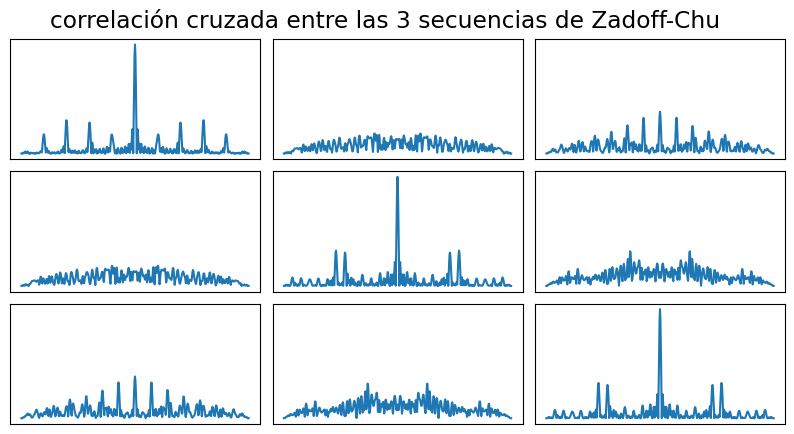

In [492]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(zc_time[j], zc_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('correlación cruzada entre las 3 secuencias de Zadoff-Chu', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

el pico de correlación se encuentra en la muestra  1792  en el tiempo  0.0004666788197609313


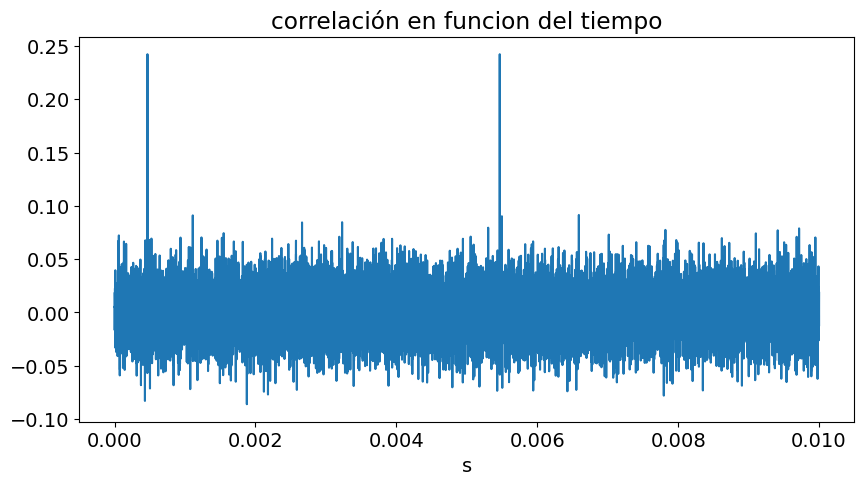

In [493]:
## zc_time[0]=> tiene como raiz 25
## zc_time[1]=> tiene como raiz 29
## zc_time[2]=> tiene como raiz 34

micorrelacion=np.correlate(zc_time[1],x,mode="same")
micorrelacion=micorrelacion[::-1]
plt.plot(t,(micorrelacion.real))
plt.title("correlación en funcion del tiempo")
plt.xlabel("s")

pico=np.argmax(micorrelacion[0:len(micorrelacion)//2])
picot=t[pico]

print("el pico de correlación se encuentra en la muestra ",pico , " en el tiempo ", picot)


Text(0.5, 0, 's')

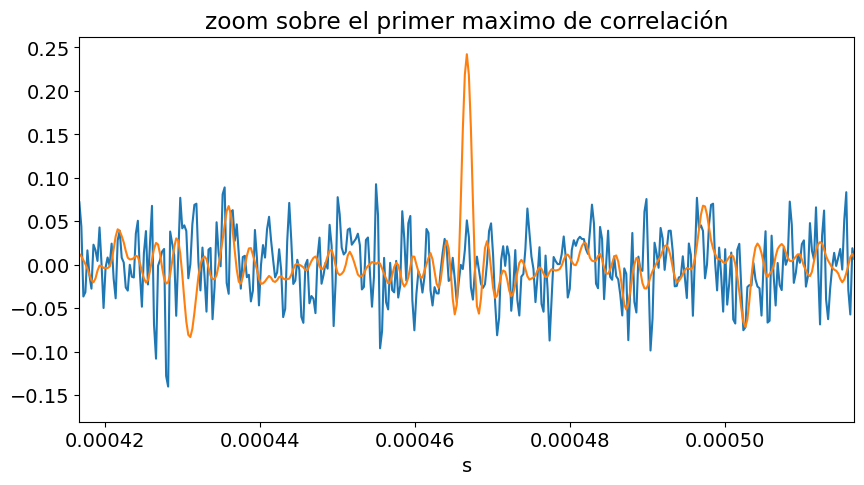

In [494]:
plt.plot(t,x.real)
plt.plot(t,micorrelacion.real)
plt.xlim([picot-50e-6,picot+50e-6])
plt.title("zoom sobre el primer maximo de correlación")
plt.xlabel("s")

In [495]:
print("pisicion de pss en la trama",(Tu+cp_len2+6*(Tu+cp_len))*ts*1e6)
print("pisicion de pss en la trama en muestras",(Tu+cp_len2+6*(Tu+cp_len)))

print("posicion detectada", picot*1e6)
print("posicion detectada en muestras", pico)

pisicion de pss en la trama 500.0
pisicion de pss en la trama en muestras 1920
posicion detectada 466.6788197609313
posicion detectada en muestras 1792


In [496]:
no_dc=np.concatenate((np.arange(31), np.arange(32, 63)))

El pico coincide con el centro del simbolo que contiene la PSS. En la variable r queda la referencia al comienzo del 7mo símbolo

63

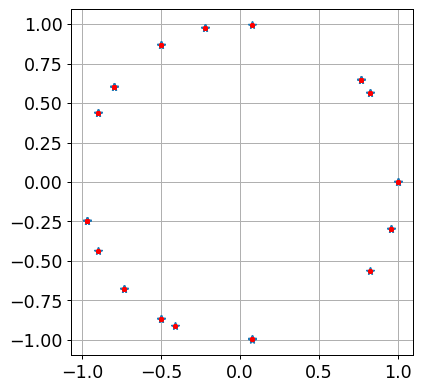

In [497]:
r=pico-Tu//2

pss_syms = np.fft.fftshift(np.fft.fft(x[r:r+Tu]))
plt.figure(dpi=90)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pss_syms[subcarriers_ss][no_dc].real,pss_syms[subcarriers_ss][no_dc].imag,"*")
plt.plot(zadoff_chu(29)[no_dc].real,zadoff_chu(29)[no_dc].imag,".r")
plt.grid(True)



len(pss_syms[subcarriers_ss])
len(zadoff_chu(29))

# SSS

Los 62 subportadores del SSS están modulados en BPSK, utilizando los puntos de la constelación 1 (para codificar el bit 0) y -1 (para codificar el bit 1). La secuencia se forma intercalando dos secuencias de 31 bits.
Si anotamos la secuencia de 62 subportadoras como d(n), donde n=0,1,…,61, entonces las secuencias d(2n) (pares) y d(2n+1) (impares), con n=0,1,…,30, se construyen por separado. Las m-sequence se utilizan como bloque básico de construcción de estas dos secuencias binarias de 31 bits. Hay tres secuencias diferentes, que se denominan s(n), c(n) y z(n).
En sharetechnote hay un grafico qe muestra la complegidad de esta construcción.

<img src="LTE_SSS_SymbolGeneration_01.png">
<img src="LTE_SSS_SymbolGeneration_02.png">
<img src="LTE_SSS_REMap_01.png">





In [498]:
# La SSS ocupa 3RB a cada lado del DC y deja 5RE sin potencia a 
# 6*12

subcarriers_sss = slice(Tu//2 - 3*12 , Tu//2 + 3*12 + 1)
print("subcarriers",Tu//2 - 3*12 , "a",Tu//2 + 3*12 + 1, " el SSB ocupa ", (Tu//2 + 3*12  + 1) - (Tu//2 - 3*12 ),"portadoras" )

subcarriers 92 a 165  el SSB ocupa  73 portadoras


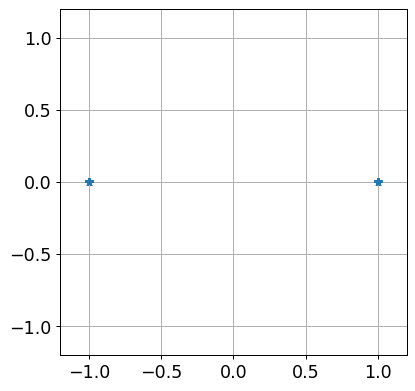

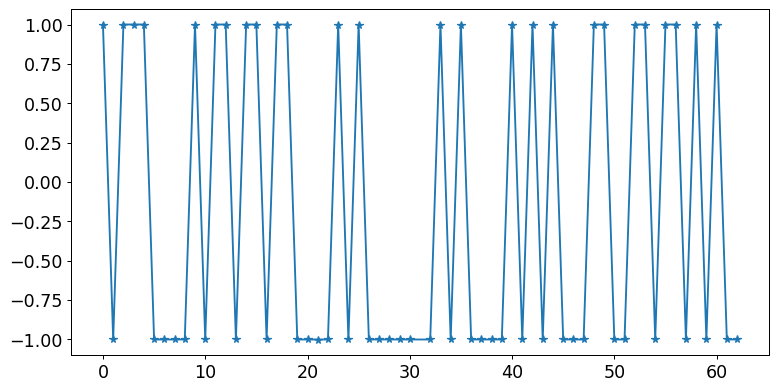

In [499]:
s=r-cp_len-Tu

sss_syms = np.fft.fftshift(np.fft.fft(x[s:s+Tu]))

plt.figure(dpi=90)
plt.plot(sss_syms[subcarriers_ss][no_dc].real,sss_syms[subcarriers_ss][no_dc].imag,"*")
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.grid(True)

plt.figure(dpi=90)
plt.plot(no_dc,sss_syms.real[subcarriers_ss][no_dc],"-*")


## Physical downlink control channel

Una vez resuleta la sincronizacion de la trama a travez de la decodificacion de SSS y MIB, el telefono está en condiciones de procesar el PDCCH.

El PDCCH comienza en la muestra de la trama 20


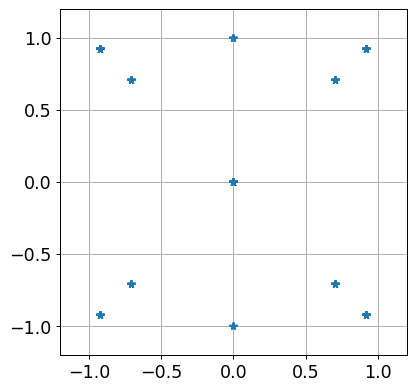

In [500]:
p=r-cp_len-(5)*(cp_len+Tu)-Tu
print("El PDCCH comienza en la muestra de la trama",p)



subcarriers_pdcch = slice(Tu//2 - Ncarriers//2, Tu//2  + 1 +Ncarriers//2)

pdcch_syms = np.fft.fftshift(np.fft.fft(x[p:p+Tu]))

plt.figure(dpi=90)
plt.plot(pdcch_syms[subcarriers_pdcch].real,pdcch_syms[subcarriers_pdcch].imag,"*")
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.grid(True)


El PDCCH o todo el canal de control del downlink esta comupesto además por PCFICH (Physical Control Format Indicator Channel) el PHICH (Physical Hybrid-ARQ Indicator Channel) y las señales de referencia (RS) del canal

# PDSCH (physical downlink share channel)



El PDSCH comienza en la muestra de la trama 842


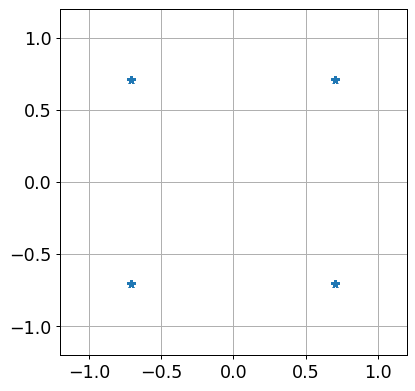

In [501]:
s=r-cp_len-(2)*(cp_len+Tu)-Tu
print("El PDSCH comienza en la muestra de la trama",s)

subcarriers_pdsch = slice(Tu//2 - Ncarriers//2, Tu//2  + 1 +Ncarriers//2)
sub=np.concatenate((np.arange(0,Ncarriers//2-1), np.arange(Ncarriers//2+1, Ncarriers)))

pdsch_syms = np.fft.fftshift(np.fft.fft(x[s:s+Tu]))

plt.figure(dpi=90)
plt.plot(pdsch_syms[subcarriers_pdsch][sub].real,pdsch_syms[subcarriers_pdsch][sub].imag,"*")
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.grid(True)

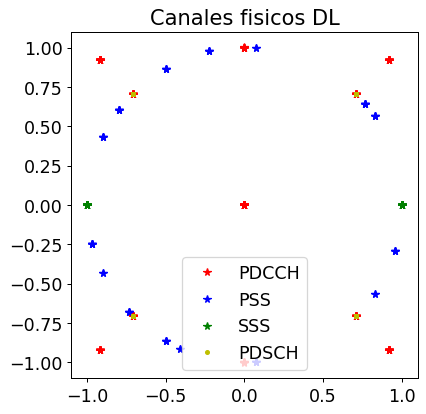

In [502]:
plt.figure(dpi=90)
plt.plot(pdcch_syms[subcarriers_pdcch].real,pdcch_syms[subcarriers_pdcch].imag,"r*",label="PDCCH")
plt.plot(pss_syms[subcarriers_ss][no_dc].real,pss_syms[subcarriers_ss][no_dc].imag,"b*",label="PSS")
plt.plot(sss_syms[subcarriers_ss][no_dc].real,sss_syms[subcarriers_ss][no_dc].imag,"g*",label="SSS")
plt.plot(pdsch_syms[subcarriers_pdsch][sub].real,pdsch_syms[subcarriers_pdsch][sub].imag,"y.",label="PDSCH")
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Canales fisicos DL")
plt.legend()

<img src="VSA_downlink.jpeg">

# LTE Uplink

In [503]:
fs = 30720000
ts=1/fs
x=np.fromfile("PUSCH100RB.dat",dtype=np.complex64)
t=np.linspace(0,len(x)*ts,len(x))




PAR 9.08592 dB


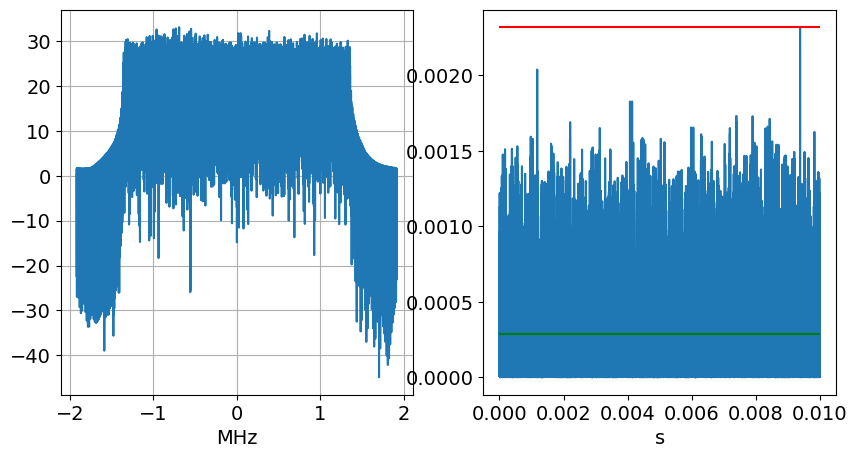

In [504]:
plt.subplot(1,2,1)
plt.plot(f/1e6,espec)
plt.xlabel("MHz")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(t,(x*np.conjugate(x)).real)
plt.hlines(np.max((x*np.conjugate(x)).real),xmin=0,xmax=t[-1],colors="r")
plt.hlines(np.mean((x*np.conjugate(x)).real),xmin=0,xmax=t[-1],colors="g")
plt.xlabel("s")

PAR=10*np.log10(np.max((x*np.conjugate(x)).real)/np.mean(x*np.conjugate(x)))
print("PAR", np.abs(PAR), "dB")

In [505]:
# en base a los parametros de LTE -> FFT 2048 fs=30720000
Tu=2048
occupied_subcarriers = np.arange(424, 1624) # este valor son las 1200 portadoras usadas
cp_len=round(4.7e-6/ts)
cp_len2=round(5.2e-6/ts)

print("cp_len =", cp_len ,"muestras")
print("cp_len2=", cp_len2, "muestras")

cp_len = 144 muestras
cp_len2= 160 muestras


In [506]:
# Schmidl & Cox
cp_corr = np.empty(x.size - cp_len - Tu, 'complex64')
for j in range(cp_corr.size):
    cp_corr[j] = -np.sum(x[j:][:cp_len] * np.conjugate(x[j+Tu:][:cp_len])) 

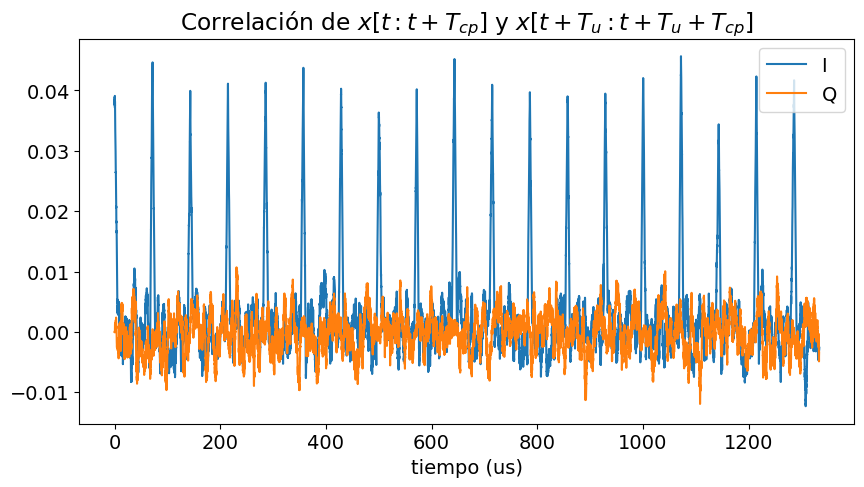

In [507]:
L = 20*Tu
t = np.arange(L)/fs*1e6
plt.plot(t, np.real(cp_corr[:L]))
plt.plot(t, np.imag(cp_corr[:L]))
plt.title('Correlación de $x[t:t+T_{cp}]$ y $x[t+T_u:t+T_u+T_{cp}]$')
plt.xlabel('tiempo (us)')
plt.legend(['I', 'Q'])

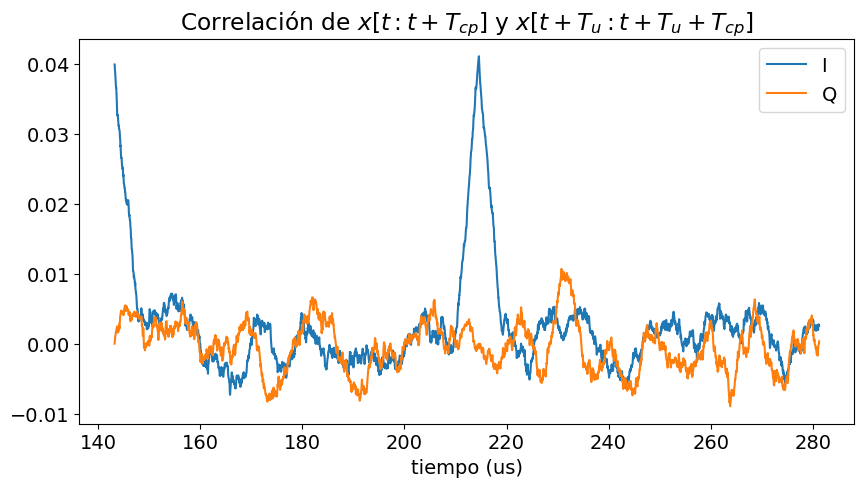

In [508]:
sel = slice(cp_len2+Tu+1*(cp_len+Tu), cp_len2+Tu+2*(cp_len+Tu)+Tu)
plt.plot(t[sel], np.real(cp_corr[sel]))
plt.plot(t[sel], np.imag(cp_corr[sel]))
plt.title('Correlación de $x[t:t+T_{cp}]$ y $x[t+T_u:t+T_u+T_{cp}]$')
plt.xlabel('tiempo (us)')
plt.legend(['I', 'Q'])

## DMRS

El DMRS está construido a partir del la secuencia de Zadoff-Chu. Se ubica en los 3eros simbolos de cada slot

In [509]:
## mia0 es la posicion del 3 símbolo donde está mapeado el DMRS

mia0=cp_len2+Tu+2*(cp_len+Tu)+cp_len
print(mia0)


6736


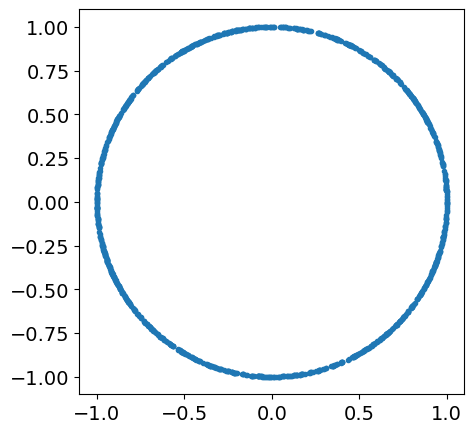

In [510]:
dmrs = np.fft.fftshift(np.fft.fft(x[mia0:mia0+Tu] * np.exp(-1j*np.pi*np.arange(Tu)/Tu)))

plt.plot(dmrs.real[occupied_subcarriers],dmrs.imag[occupied_subcarriers],".")
plt.gca().set_aspect('equal', 'box')

## DFT-S-OFDM

La demodulación de un símbolo DFT-S-OFDM comienza de la misma manera que con cualquier símbolo OFDM regular. Tomamos las 2048 muestras que creemos que están mejor alineadas con el tiempo útil de nuestro símbolo y realizamos una FFT de 2048 puntos. Ahora necesitamos seleccionar los M bins de la FFT correspondientes a las subportadoras ocupadas por el símbolo SC-FDMA y realizar una IFFT de M puntos. Esto nos dará los M símbolos QPSK (o QAM) transportados en este símbolo SC-FDMA.

In [511]:
## mia0 es la posicion del 2 símbolo
mia0=cp_len2+Tu+1*(cp_len+Tu)+cp_len
print(mia0)

4544


(-1.5, 1.5)

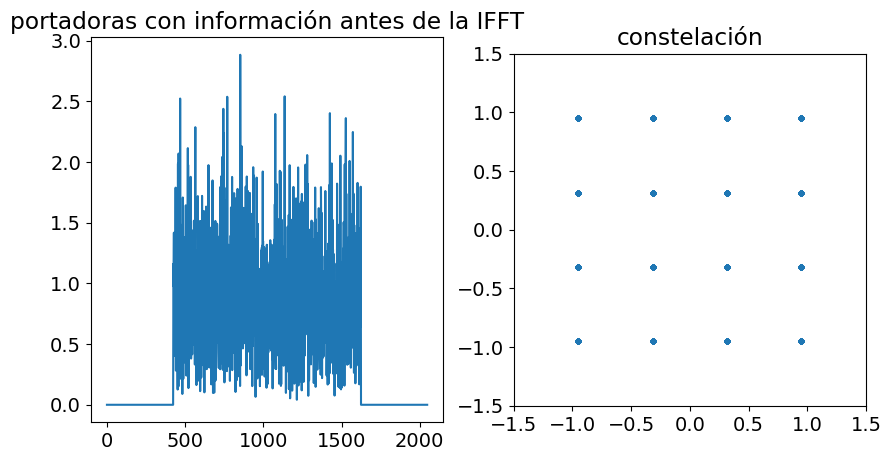

In [512]:
demod = np.fft.fftshift(np.fft.fft(x[mia0:mia0+Tu] * np.exp(-1j*np.pi*np.arange(Tu)/Tu)))
#plt.figure()
plt.subplot(1,2,1)
plt.title("portadoras con información antes de la IFFT")
plt.plot(np.abs(demod))
# aca se recueran la informacion de los simbolos distribuidos en todas las portadoras con la IFFT
demod = np.fft.ifft(demod[occupied_subcarriers])*np.sqrt(occupied_subcarriers.size)
plt.subplot(1,2,2)
plt.gca().set_aspect('equal', 'box')
plt.title("constelación")
plt.plot(demod.real,demod.imag,".")
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

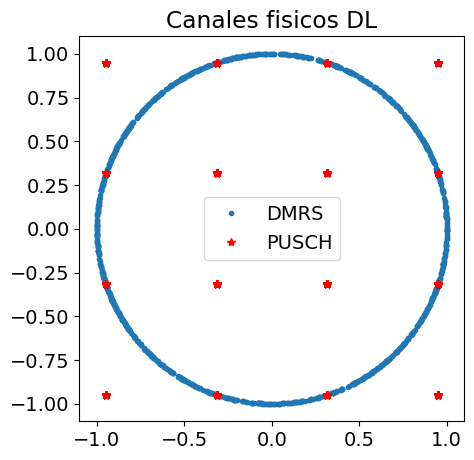

In [517]:
plt.plot(dmrs.real[occupied_subcarriers],dmrs.imag[occupied_subcarriers],".",label="DMRS")
plt.plot(demod.real,demod.imag,"r*",label="PUSCH")

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Canales fisicos DL")
plt.legend()

<img src="VSA_uplink.jpg">